**WHAT IS CROWD COUNTING?**

Crowd counting is a specific task within the field of Computer Vision that involves automatically estimating the number of individuals in a digital image or video sequence. Unlike simple object detection, crowd counting must often deal with highly congested environments where individuals are partially obscured (occlusion), vary significantly in size due to perspective (scale variation), and appear in diverse lighting conditions.

The Primary Objective: the main goal of crowd counting is to generate an accurate estimate of the total population in a given area. Modern approaches typically move beyond just providing a single integer; they aim to produce a density map.

Spatial Distribution: By generating a density map, the model shows where the crowd is most concentrated, not just how many people are there.

Overcoming Overlap: Density-based methods are particularly effective because they don't need to identify every single person as a distinct "box," which is nearly impossible in extremely dense crowds (e.g., at a stadium or a protest).

**- Our Project Approach**
For this project, our primary focus was to experiment with various deep learning frameworks to identify the most effective solution for this challenge.

Our Strategy: We attempted to apply several different architectures in an effort to achieve a model capable of delivering high-accuracy results.

To do this, we conducted a comparative analysis between:

Established Architectures: Implementing models and codebases found through open-source repositories and web resources.

State-of-the-Art Papers: Recreating or adapting cutting-edge techniques described in recent academic research papers to see if they offered a significant performance boost over standard methods.

By benchmarking these different approaches against one another, we aimed to find the optimal balance between computational efficiency and counting precision.

**- REFERENCE**
- [1st example](https://www.kaggle.com/fmena14/crowd-counting)

- [2nd example](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Zhang_Single-Image_Crowd_Counting_CVPR_2016_paper.pdf )

- [3rd example](https://arxiv.org/pdf/1802.10062.pdf)

- [4th example](https://github.com/gjy303)

- [5th example](https://github.com/gjy3035/Awesome-Crowd-Counting5/Awesome-Crowd-Counting )

**LIBRARIES**
On the following chunk we have imported the libraries that are necessary for all the models.

In [ ]:
# import standar libraries for
import os
import numpy as np
import pandas as pd
import cv2
import random
from datetime import datetime
import glob
from typing import Optional, List, Tuple
from PIL import Image
from scipy.optimize import linear_sum_assignment
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt


# import libraries useful for architectures
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import torchvision.models as models
import torch.nn.functional as F
from torchvision import models

CONFIGURATION

In [ ]:
# fix the seed for the reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# dimension for the target images
TARGET_IMG_SIZE = (256, 256)

# fix batch size, epochs and optimization
BATCH_SIZE = 16
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
CHECKPOINT_PATH = "/kaggle/working/mcnn_best.pth" # save the path of the best model during the training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu if it is available if not use the cpu
print("Device:", device)

Device: cuda


The dataset that has been used is available at <https://www.kaggle.com/datasets/fmena14/crowd-counting>.

**FIRST MODEL**

Multicomlumn CNN

In [ ]:
path = kagglehub.dataset_download("fmena14/crowd-counting") # path for the dataset
print("path to dataset files:", path)

images_path = os.path.join(path, "images.npy")
labels_path = os.path.join(path, "labels.csv")

# loading images
images = np.load(images_path)
labels = pd.read_csv(labels_path)
print("loaded images shape:", images.shape)
print("labels head:\n", labels.head())

labels = labels.rename(columns={'count': 'people'}) # rename the column count in people
labels = labels[['id', 'people']].copy()
labels['people'] = labels['people'].astype(float) # convert the label people in a float

# convert labels to zero-based indexing to match images.npy in order to ensure correct alignment between images and labels avoiding errors
labels['id'] = labels['id'].astype(int) - 1
labels = labels.sort_values('id').reset_index(drop = True) # sort labels by ID to ensure alignment
assert labels['id'].tolist() == list(range(len(labels))) # check

# to reduce the computational cost it is necessary to resize the images
def preprocess_image(img, target_size):
    img = cv2.resize(img, target_size, interpolation = cv2.INTER_LINEAR) # it resizes the image to the target_size
    # ensure uint8 [0,255]
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 1 if img.max() <= 1 else 255)
        if img.max() <= 1:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)
    return img

N = images.shape[0]
H, W = TARGET_IMG_SIZE

processed = np.empty((N, H, W, 3), dtype = np.uint8)

for i in range(N):
    processed[i] = preprocess_image(images[i], TARGET_IMG_SIZE)

images = processed
print("processed images shape:", images.shape)

counts = labels['people'].values # extract the target values

# split the dataset into train val and test set
x_train_full, x_test, y_train_full, y_test = train_test_split(images, counts, test_size = 0.2, random_state = RANDOM_SEED)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.15, random_state = RANDOM_SEED)
print(f"train: {x_train.shape[0]}, val: {x_val.shape[0]}, test: {x_test.shape[0]}")

# build the density-map on a grid with dim H/4 x W/4
class CrowdCountDataset(Dataset):
    def __init__(self, images_np, counts_np, normalize=True):
        assert len(images_np) == len(counts_np) # check if the number of images is the same of the label
        self.images = images_np
        self.counts = counts_np.astype(np.float32) # transform counts into a float
        self.normalize = normalize # normalize the images
        H = self.images.shape[1] # image height
        W = self.images.shape[2] # image width
        self.target_h = H // 4 # density-map height
        self.target_w = W // 4 #density-map width

        if self.target_h <= 0 or self.target_w <= 0: # cancellerei anche questo if!!!!!!!!!!!!!!!!!!!!!!!!!!
            raise ValueError(f"Immagini troppo piccole H={H}, W={W}")

    def __len__(self):
        return len(self.images) # return the numebr of examples

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.float32) # convert images into float
        if self.normalize:
            img = img / 255.0 # normalize the images
        img_t = torch.from_numpy(img).permute(2, 0, 1).float() # convert into a torch tensor
        count = float(self.counts[idx]) # count for the images
        area = float(self.target_h * self.target_w) # density-map's number of pixels
        fill = (count / area) if area > 0 else 0.0
        density_map = torch.full((1, self.target_h, self.target_w), fill_value=fill, dtype=torch.float32) # create the density-map
        return img_t, density_map

train_dataset = CrowdCountDataset(x_train, y_train)
val_dataset = CrowdCountDataset(x_val, y_val)
test_dataset = CrowdCountDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, pin_memory = True)

print("batches - train:", len(train_loader), "val:", len(val_loader), "test:", len(test_loader))

Mounting files to /kaggle/input/crowd-counting...
path to dataset files: /kaggle/input/crowd-counting
loaded images shape: (2000, 480, 640, 3)
labels head:
    id  count
0   1     35
1   2     41
2   3     41
3   4     44
4   5     41
processed images shape: (2000, 256, 256, 3)
train: 1360, val: 240, test: 400
batches - train: 85 val: 15 test: 25


FIRST MODEL: MCNN

The MCNN (Multi-column Convolutional Neural Network) is a landmark architecture in the field of crowd counting, specifically designed to address the challenge of scale variation (the fact that people can appear very large or very small depending on their distance from the camera).

The core idea behind MCNN is to use multiple parallel branches (columns) to process the same input image:
- Diverse Receptive Fields: Each of the three columns uses filters of different sizes (Small, Medium, and Large).
- The Large-filter column is optimized to detect people close to the camera (large heads).
- The Small-filter column is better at detecting people far away in the background (small heads).
- Feature Fusion: The features extracted from these three branches are concatenated and mapped through further convolutional layers to produce the final output.
- Density Map Estimation: Instead of outputting a single number, MCNN generates a density map. The sum of all pixel values in this map provides the estimated total count of people in the scene.

In [ ]:
# build a multicolumn CNN
class MCNNColumn(nn.Module):
    def __init__(self, in_channels, c1, c2, k1, k2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, c1, kernel_size = k1, stride = 1, padding = k1//2) # convolutional layer
        self.conv2 = nn.Conv2d(c1, c2, kernel_size = k2, stride = 1, padding = k2//2) # convolutional layer
        self.pool = nn.MaxPool2d(2, 2) # max pool layer
        self.relu = nn.ReLU(inplace = True) # apply ReLu as the activation function

    def forward(self, x): # forward pass
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        return x

# compute three columns
class MCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.column1 = MCNNColumn(in_channels = 3, c1 = 24, c2 = 48, k1 = 5, k2 = 3) # column1 with smaller filters
        self.column2 = MCNNColumn(in_channels = 3, c1 = 20, c2 = 40, k1 = 7, k2 = 5) # column2 with larger kernels
        self.column3 = MCNNColumn(in_channels = 3, c1 = 16, c2 = 32, k1 = 9, k2 = 7) # comlumn3 with even larger kernels
        self.fuse = nn.Conv2d(in_channels = 48 + 40 + 32, out_channels = 1, kernel_size = 1, stride = 1, padding = 0) # produces the density-map

    def forward(self, x): # forward pass
        x1 = self.column1(x) # B x 48 x H/4 x W/4
        x2 = self.column2(x) # B x 40 x H/4 x W/4
        x3 = self.column3(x) # B x 32 x H/4 x W/4
        x = torch.cat([x1, x2, x3], dim=1)
        density = self.fuse(x)
        return density

def density_loss(pred, gt):
    return 0.5 * torch.mean((pred - gt) ** 2) # MSE loss

model = MCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY) # adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.1) # reduce the lr by gamma every step_size

def train_one_epoch(model, loader, optimizer, device):
    model.train() # puts the model into training mode
    running_loss = 0.0
    running_mae = 0.0
    count = 0
    for images, gt_density in loader:
        images = images.to(device) # bring data to the device
        gt_density = gt_density.to(device) # bring data to the device
        optimizer.zero_grad() # initialize the gradients
        pred_density = model(images) # forward pass

        if pred_density.shape != gt_density.shape:
            raise RuntimeError(f"Shape mismatch pred {pred_density.shape} vs gt {gt_density.shape}") # cancellerei questo check inutile!!!!!!!!

        loss = density_loss(pred_density, gt_density) # compute the loss
        loss.backward() # backward phase
        optimizer.step() # aims to find the best weights
        running_loss += loss.item()
        pred_count = pred_density.sum(dim=[1,2,3]) # compute the prediciton
        gt_count = gt_density.sum(dim=[1,2,3])
        mae = torch.abs(pred_count - gt_count).mean() # medium mae
        running_mae += mae.item() # accumulate mae per-batch
        count += 1
    return (running_loss / count) if count else 0.0, (running_mae / count) if count else 0.0

@torch.no_grad() # disable gradient calculation
def validate(model, loader, device):
    model.eval() # puts the model into validation mode
    running_loss = 0.0
    running_mae = 0.0
    count = 0
    for images, gt_density in loader:
        images = images.to(device)
        gt_density = gt_density.to(device)

        pred_density = model (images)
        loss = density_loss(pred_density, gt_density)
        running_loss += loss.item()
        pred_count = pred_density.sum(dim = [1,2,3])
        gt_count = gt_density.sum(dim = [1,2,3])
        mae = torch.abs (pred_count - gt_count).mean()
        running_mae += mae.item()
        count += 1
    return (running_loss / count) if count else 0.0, (running_mae / count) if count else 0.0

# training phase
best_val_mae = float('inf')
history = []
start_time = datetime.now()

for epoch in range(NUM_EPOCHS):
    train_loss, train_mae = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_mae = validate(model, val_loader, device)
    scheduler.step()

    history.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_mae': train_mae,
                    'val_loss': val_loss, 'val_mae': val_mae})

    print(f"epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"train Loss: {train_loss:}, train MAE: {train_mae:} | "
          f"val Loss: {val_loss:}, val MAE: {val_mae:}")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_mae': val_mae,
            'history': history
        }, CHECKPOINT_PATH)
        print("saved best model to", CHECKPOINT_PATH) # save the model with the best mae

end_time = datetime.now()
print("training duration:", end_time - start_time)

ckpt = torch.load(CHECKPOINT_PATH, map_location = device) # tensors are saved
model.load_state_dict(ckpt['model_state_dict']) # weights are saved
print("loaded checkpoint with val_mae =", ckpt.get('val_mae'))

test_loss, test_mae = validate(model, test_loader, device)
print(f"Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.4f}")

# prediction on test set
model.eval()
with torch.no_grad():
    for i, (img, gt) in enumerate(test_loader):
        img = img.to(device)
        gt = gt.to(device)
        pred = model(img)
        pred_counts = pred.sum(dim = [1, 2, 3]).cpu().numpy()
        gt_counts = gt.sum(dim = [1, 2, 3]).cpu().numpy()
        for j in range(len(pred_counts)):
            print(f"Batch {i} Sample {j}: Pred = {pred_counts[j]:.2f}, GT = {gt_counts[j]:.2f}")
        break

hist_df = pd.DataFrame(history)
hist_df.to_csv("/kaggle/working/training_history.csv", index = False)
print("history saved in /kaggle/working/training_history.csv")

epoch [1/50] train Loss: 0.0001970493364805246, train MAE: 29.790966291988596 | val Loss: 3.871120570693165e-05, val MAE: 8.108748245239259
saved best model to /kaggle/working/mcnn_best.pth
epoch [2/50] train Loss: 2.365192317751387e-05, train MAE: 7.884440253762638 | val Loss: 1.4062021364225075e-05, val MAE: 7.954572836558024
saved best model to /kaggle/working/mcnn_best.pth
epoch [3/50] train Loss: 1.1413200049633708e-05, train MAE: 7.016675710678101 | val Loss: 1.0813578167775025e-05, val MAE: 9.48812739054362
epoch [4/50] train Loss: 8.750539906459915e-06, train MAE: 6.572098291621488 | val Loss: 7.491532657392478e-06, val MAE: 5.628210926055909
saved best model to /kaggle/working/mcnn_best.pth
epoch [5/50] train Loss: 7.71823916318895e-06, train MAE: 6.588237571716308 | val Loss: 6.632324342111436e-06, val MAE: 5.531621106465658
saved best model to /kaggle/working/mcnn_best.pth
epoch [6/50] train Loss: 6.5286796544729865e-06, train MAE: 5.951110172271728 | val Loss: 5.92260864020

As for the first model in the entire project we opted for MAE as metric, this is because it's the standard. It's straightforward understand why, It gives the mean of how much we go away from the real answer

In [ ]:
# for this try we change the number of epochs and obviously the checkpoint_path
NUM_EPOCHS = 60
CHECKPOINT_PATH = "/kaggle/working/mcnn_count_regressor_best.pth"

# the dataset loading, preprocessing, and splitting steps are already performed in the previous chunk

# crowd count dataset
class CrowdCountScalarDataset(Dataset):
    def __init__(self, images_np, counts_np, normalize = True):
        assert len(images_np) == len(counts_np) # check if the number of images is the same of the label
        self.images = images_np
        self.counts = counts_np.astype(np.float32) # transform counts into a float
        self.normalize = normalize # normalize the images

    def __len__(self):
        return len(self.images) # return the numebr of examples

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.float32) # convert images into float
        if self.normalize:
            img = img / 255.0 # normalize the images
        img_t = torch.from_numpy(img).permute(2, 0, 1).float()  # convert into a torch tensor
        count = torch.tensor(self.counts[idx], dtype = torch.float32) # count for the images
        return img_t, count

train_dataset = CrowdCountScalarDataset(x_train, y_train)
val_dataset = CrowdCountScalarDataset(x_val, y_val)
test_dataset = CrowdCountScalarDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, pin_memory = True)

# multicolumn CNN with head of regression on the count
class MCNNColumn(nn.Module):
    def __init__(self, in_channels, c1, c2, k1, k2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, c1, kernel_size = k1, stride = 1, padding = k1//2) # convolutional layer
        self.conv2 = nn.Conv2d(c1, c2, kernel_size = k2, stride = 1, padding = k2//2) # convolutional layer
        self.pool = nn.MaxPool2d(2, 2) # max pool layer
        self.relu = nn.ReLU(inplace = True) # apply ReLu as the activation function

    def forward(self, x): # forward pass
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        return x

# compute three columns
class MCNNCountRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.column1 = MCNNColumn(in_channels = 3, c1 = 24, c2 = 48, k1 = 5, k2 = 3) # column1 with smaller filters
        self.column2 = MCNNColumn(in_channels = 3, c1 = 20, c2 = 40, k1 = 7, k2 = 5) # column2 with larger kernels
        self.column3 = MCNNColumn(in_channels = 3, c1 = 16, c2 = 32, k1 = 9, k2 = 7) # comlumn3 with even larger kernels
        self.fuse = nn.Conv2d(in_channels = 48 + 40 + 32, out_channels = 1, kernel_size = 1, stride = 1, padding = 0) # produces the density-map
        # pool to 1x1 and a small regressor
        self.pool_to_scalar = nn.AdaptiveAvgPool2d((1,1))
        self.regressor = nn.Sequential(nn.Linear(1, 64), nn.ReLU(inplace = True),
                                       nn.Linear(64, 1))

    def forward(self, x): # forward pass
        x1 = self.column1(x)
        x2 = self.column2(x)
        x3 = self.column3(x)
        x = torch.cat([x1, x2, x3], dim = 1)
        density = self.fuse(x) # (B, 1, H', W')
        pooled = self.pool_to_scalar(density) # (B, 1, 1, 1)
        pooled = pooled.view(pooled.size(0), -1) # (B, 1)
        count = self.regressor(pooled) # (B, 1)
        count = count.squeeze(1) # (B,)
        count = torch.relu(count) # non-negative prediction
        return count, density # returns also density map, this is optional btw

def count_loss(pred_count, gt_count):
    return torch.mean((pred_count - gt_count) ** 2) # mse loss

model = MCNNCountRegressor().to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY) # adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.1) # reduce the lr by gamma every step_size

def train_one_epoch(model, loader, optimizer, device):
    model.train() # puts the model into training mode
    running_loss = 0.0
    running_mae = 0.0
    nb = 0
    for images, counts in loader:
        images = images.to(device) # bring data to the device
        counts = counts.to(device) # bring data to the device
        optimizer.zero_grad() # initialize the gradients
        pred_counts, _ = model(images) # forward pass
        loss = count_loss(pred_counts, counts) # compute the loss
        loss.backward() # backward phase
        optimizer.step() # aims to find the best weights
        running_loss += loss.item()
        mae = torch.abs(pred_counts - counts).mean().item()
        running_mae += mae
        nb += 1
    return (running_loss / nb) if nb else 0.0, (running_mae / nb) if nb else 0.0

@torch.no_grad() # disable gradient calculation
def validate(model, loader, device):
    model.eval() # puts the model into validation mode
    running_loss = 0.0
    running_mae = 0.0
    nb = 0
    for images, counts in loader:
        images = images.to(device)
        counts = counts.to(device)
        pred_counts, _ = model(images)
        loss = count_loss(pred_counts, counts)
        running_loss += loss.item()
        mae = torch.abs(pred_counts - counts).mean().item()
        running_mae += mae
        nb += 1
    return (running_loss / nb) if nb else 0.0, (running_mae / nb) if nb else 0.0

best_val_mae = float('inf')
history = []
start_time = datetime.now()

for epoch in range(NUM_EPOCHS):
    train_loss, train_mae = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_mae = validate(model, val_loader, device)
    scheduler.step()
    history.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_mae': train_mae, 'val_loss': val_loss, 'val_mae': val_mae})
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] train Loss: {train_loss:}, train MAE: {train_mae:} | val Loss: {val_loss:}, val MAE: {val_mae:}")
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'val_mae': val_mae, 'history': history}, CHECKPOINT_PATH)
        print("saved best model to", CHECKPOINT_PATH)

end_time = datetime.now()
print("Training duration:", end_time - start_time)


ckpt = torch.load(CHECKPOINT_PATH, map_location = device) # tensors are saved
model.load_state_dict(ckpt['model_state_dict']) # weights are saved
print("checkpoint loaded with val_mae =", ckpt.get('val_mae'))

test_loss, test_mae = validate(model, test_loader, device)
print(f"test Loss: {test_loss:.6f}, test MAE: {test_mae:.4f}")

# prediction on test set
model.eval()
with torch.no_grad():
    for i, (img, gt) in enumerate(test_loader):
        img = img.to(device)
        gt = gt.to(device)
        pred_counts, pred_density = model(img)
        pred_counts = pred_counts.cpu().numpy()
        gt_np = gt.cpu().numpy()
        for j in range(len(pred_counts)):
            print(f"Batch {i} Sample {j}: Pred = {pred_counts[j]:.2f}, GT = {gt_np[j]:.2f}")
        break

pd.DataFrame(history).to_csv("/kaggle/working/training_history_count_regression.csv", index = False)
print("History saved in /kaggle/working/training_history_count_regression.csv")

Epoch [1/60] train Loss: 1019.4, train MAE: 31.16470588235294 | val Loss: 1017.4333333333333, val MAE: 31.15
saved best model to /kaggle/working/mcnn_count_regressor_best.pth
Epoch [2/60] train Loss: 1019.4, train MAE: 31.16470588235294 | val Loss: 1017.4333333333333, val MAE: 31.15
Epoch [3/60] train Loss: 1019.4, train MAE: 31.16470588235294 | val Loss: 1017.4333333333333, val MAE: 31.15
Epoch [4/60] train Loss: 1019.4, train MAE: 31.16470588235294 | val Loss: 1017.4333333333333, val MAE: 31.15
Epoch [5/60] train Loss: 1019.4, train MAE: 31.16470588235294 | val Loss: 1017.4333333333333, val MAE: 31.15
Epoch [6/60] train Loss: 1019.4, train MAE: 31.16470588235294 | val Loss: 1017.4333333333333, val MAE: 31.15
Epoch [7/60] train Loss: 1019.4, train MAE: 31.16470588235294 | val Loss: 1017.4333333333333, val MAE: 31.15
Epoch [8/60] train Loss: 1019.4, train MAE: 31.16470588235294 | val Loss: 1017.4333333333333, val MAE: 31.15
Epoch [9/60] train Loss: 1019.4, train MAE: 31.16470588235294 

SECOND MODEL: Crowd Counting Regressor based on a ResNet-18 architecture

Unlike the MCNN which generates density maps, this model treats crowd counting as a direct global regression task.

Here is a brief breakdown of the implementation:

1. Model Architecture
The model uses a ResNet-18 backbone initialized without pre-trained weights (weights=None).
The final classification layer (fc) is replaced with an Identity block to extract a high-level feature vector.
A custom Regression Head is attached, consisting of a Linear layer (128 units), ReLU activation, Dropout for regularization, and a final Linear layer that outputs a single numerical value.

2. The Log-Target Strategy
One of the most important technical choices in this code is the use of the Log-Space Transformation:
Target: Instead of predicting the raw count, the model predicts log(1+count), the reason is because the Crowd data is often skewed
a few images might have hundreds of people while most have few). Using the log function compresses the range of the target values, making the training more stable and helping the MSE (Mean Squared Error) loss converge more effectively.


3. Preprocessing & Augmentation

In [ ]:
# for this try we change the number of epochs and obviously the checkpoint_path
NUM_EPOCHS = 50
CHECKPOINT = "/kaggle/working/resnet_log_no_pretrain_best.pth"

# the dataset loading, preprocessing, and splitting steps are already performed in the previous chunk

imagenet_mean = [0.485, 0.456, 0.406] # values computed using the imagenet dataset
imagenet_std  = [0.229, 0.224, 0.225] # values computed using the imagenet dataset

# data augmentation
train_transforms = T.Compose([
    T.ToPILImage(), # converts the image to a pillow
    T.RandomResizedCrop(TARGET_IMG_SIZE, scale = (0.8, 1.0)), # cropping
    T.RandomHorizontalFlip(p = 0.5), # randomly flips the image horizontally with a 50% probability
    T.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.1, hue = 0.02), # it changes the colors
    T.ToTensor(), # converts the pil image to a tensor
    T.Normalize(mean = imagenet_mean, std = imagenet_std), # normalization step using the imagenet values
])

val_transforms = T.Compose([
    T.ToPILImage(), # converts the image to a pillow
    T.Resize(TARGET_IMG_SIZE), # resize
    T.ToTensor(), # converts the pil image to a tensor
    T.Normalize(mean = imagenet_mean, std = imagenet_std), # normalization step using the imagenet values
])

# crowd count dataset
class CrowdCountLogDataset(Dataset):
    def __init__(self, images_np, counts_np, transforms = None):
        assert len(images_np) == len(counts_np) # check if the number of images is the same
        self.images = images_np
        self.counts = counts_np.astype(np.float32) # transform counts into a float
        self.transforms = transforms # transform the images

    def __len__(self):
        return len(self.images) # return the number of examples

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transforms is not None:
            img_t = self.transforms(img)   # tensor normalized
        else:
            img_t = T.ToTensor()(img)
        count = float(self.counts[idx])
        log_count = np.log1p(count).astype(np.float32) # target = log(1 + count)
        return img_t, torch.tensor(log_count, dtype=torch.float32)

train_dataset = CrowdCountLogDataset(x_train, y_train, transforms = train_transforms)
val_dataset = CrowdCountLogDataset(x_val, y_val, transforms = val_transforms)
test_dataset = CrowdCountLogDataset(x_test, y_test, transforms = val_transforms)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, pin_memory = True)

# resnet18 without pretraining (weights = None)
class ResNetLogRegressorNoPretrain(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights = None) # the weights are randomly initialized
        in_f = self.backbone.fc.in_features # captures the number of input features that this final layer would receive
        self.backbone.fc = nn.Identity() # outputs the feature vector
        self.regressor = nn.Sequential(
            nn.Linear(in_f, 128), # fully connected layer mapping the backbone features to 128 dimensions
            nn.ReLU(inplace = True), # relu activation function
            nn.Dropout(0.3),
            nn.Linear(128, 1) # final fully connected layer
        )
        # weight Initialization
        for m in self.regressor:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        feats = self.backbone(x) # input image is passed through the backbone
        out = self.regressor(feats).squeeze(1) # squeeze into a 1D tensor
        return out

model = ResNetLogRegressorNoPretrain().to(device)
criterion = nn.MSELoss()  # MSE sui log(1+count)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY) # adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1) # reduce the lr by gamma every step_size

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    nb = 0
    for imgs, log_counts in loader:
        imgs = imgs.to(device) # bring data to the device
        log_counts = log_counts.to(device) # bring data to the device
        optimizer.zero_grad() # initialize the gradients
        preds = model(imgs) # forward pass
        loss = criterion(preds, log_counts) # compute the loss
        loss.backward() # backward phase
        optimizer.step() # aims to find the best weights
        running_loss += loss.item()
        pred_counts = torch.expm1(preds)
        gt_counts = torch.expm1(log_counts)
        mae = torch.abs(pred_counts - gt_counts).mean().item()
        running_mae += mae
        nb += 1
    return (running_loss/nb) if nb else 0.0, (running_mae/nb) if nb else 0.0

@torch.no_grad() # disable gradient calculation
def validate(model, loader, device):
    model.eval() # puts the model into validation mode
    running_loss = 0.0
    running_mae = 0.0
    nb = 0
    for imgs, log_counts in loader:
        imgs = imgs.to(device) # bring data to the device
        log_counts = log_counts.to(device) # bring data to the device
        preds = model(imgs)
        loss = criterion(preds, log_counts)
        running_loss += loss.item()
        pred_counts = torch.expm1(preds)
        gt_counts = torch.expm1(log_counts)
        mae = torch.abs(pred_counts - gt_counts).mean().item()
        running_mae += mae
        nb += 1
    return (running_loss/nb) if nb else 0.0, (running_mae/nb) if nb else 0.0

# training phase
best_val_mae = float('inf')
history = []
start = datetime.now()
for epoch in range(NUM_EPOCHS):
    train_loss, train_mae = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_mae = validate(model, val_loader, device)
    scheduler.step()
    history.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_mae': train_mae, 'val_loss': val_loss, 'val_mae': val_mae})
    print(f"epoch {epoch + 1}/{NUM_EPOCHS}  train Loss {train_loss:.6f}  train MAE {train_mae:.4f}  |  val Loss {val_loss:.6f}  val MAE {val_mae:.4f}")
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
                    'val_mae': val_mae, 'history': history}, CHECKPOINT)
        print("saved best checkpoint:", CHECKPOINT)

end = datetime.now()
print("training duration:", end - start)

ckpt = torch.load(CHECKPOINT, map_location = device) # tensors are saved
model.load_state_dict(ckpt['model_state_dict']) # weight are saved
print("loaded checkpoint with val_mae =", ckpt.get('val_mae'))

test_loss, test_mae = validate(model, test_loader, device)
print(f"test Loss: {test_loss:.6f}, test MAE: {test_mae:.4f}")

# prediction on test set
model.eval()
with torch.no_grad():
    for i, (imgs, log_counts) in enumerate(test_loader):
        imgs = imgs.to(device); log_counts = log_counts.to(device)
        preds = model(imgs)
        pred_counts = torch.expm1(preds).cpu().numpy()
        gt_counts = torch.expm1(log_counts).cpu().numpy()
        for j in range(len(pred_counts)):
            print(f"batch {i} sample {j}: pred = {pred_counts[j]:.2f}, GT = {gt_counts[j]:.2f}")
        break

pd.DataFrame(history).to_csv("/kaggle/working/history_resnet_log_no_pretrain.csv", index = False)
print("Saved history to /kaggle/working/history_resnet_log_no_pretrain.csv")

epoch 1/50  train Loss 0.779729  train MAE 23.7611  |  val Loss 0.095908  val MAE 9.5547
saved best checkpoint: /kaggle/working/resnet_log_no_pretrain_best.pth
epoch 2/50  train Loss 0.279511  train MAE 13.7310  |  val Loss 0.029559  val MAE 4.2750
saved best checkpoint: /kaggle/working/resnet_log_no_pretrain_best.pth
epoch 3/50  train Loss 0.221186  train MAE 12.3184  |  val Loss 0.058983  val MAE 6.0099
epoch 4/50  train Loss 0.207136  train MAE 11.8198  |  val Loss 0.070727  val MAE 7.9627
epoch 5/50  train Loss 0.185761  train MAE 11.2514  |  val Loss 0.110993  val MAE 8.6361
epoch 6/50  train Loss 0.184444  train MAE 11.1484  |  val Loss 0.029845  val MAE 4.3803
epoch 7/50  train Loss 0.191803  train MAE 11.4712  |  val Loss 0.029306  val MAE 4.3633
epoch 8/50  train Loss 0.170430  train MAE 10.7362  |  val Loss 0.193875  val MAE 16.6798
epoch 9/50  train Loss 0.177921  train MAE 11.0260  |  val Loss 0.019087  val MAE 3.3767
saved best checkpoint: /kaggle/working/resnet_log_no_pre

In [ ]:
CHECKPOINT = "/kaggle/working/resnet_log_best.pth"

# same as before but this time with pretrained
class ResNetLogRegressor(nn.Module):
    def __init__(self, pretrained = True):
        super().__init__()
        self.backbone = models.resnet18(pretrained = pretrained)
        in_f = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.regressor = nn.Sequential(
            nn.Linear(in_f, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        feats = self.backbone(x)
        out = self.regressor(feats).squeeze(1)
        return out

model = ResNetLogRegressor(pretrained = True).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1)

best_val_mae = float('inf')
history = []
start = datetime.now()
for epoch in range(NUM_EPOCHS):
    train_loss, train_mae = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_mae = validate(model, val_loader, device)
    scheduler.step()
    history.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_mae': train_mae, 'val_loss': val_loss, 'val_mae': val_mae})
    print(f"epoch {epoch + 1}/{NUM_EPOCHS}  train Loss {train_loss:.6f}  train MAE {train_mae:.4f}  |  val Loss {val_loss:.6f}  val MAE {val_mae:.4f}")
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
                    'val_mae': val_mae, 'history': history}, CHECKPOINT)
        print("saved best checkpoint:", CHECKPOINT)

end = datetime.now()
print("Training duration:", end - start)

ckpt = torch.load(CHECKPOINT, map_location = device)
model.load_state_dict(ckpt['model_state_dict'])
print("loaded checkpoint with val_mae =", ckpt.get('val_mae'))

test_loss, test_mae = validate(model, test_loader, device)
print(f"test Loss: {test_loss:.6f}, test MAE: {test_mae:.4f}")

model.eval()
with torch.no_grad():
    for i, (imgs, log_counts) in enumerate(test_loader):
        imgs = imgs.to(device); log_counts = log_counts.to(device)
        preds = model(imgs)
        pred_counts = torch.expm1(preds).cpu().numpy()
        gt_counts = torch.expm1(log_counts).cpu().numpy()
        for j in range(len(pred_counts)):
            print(f"batch {i} sample {j}: pred = {pred_counts[j]:.2f}, GT = {gt_counts[j]:.2f}")
        break

pd.DataFrame(history).to_csv("/kaggle/working/history_resnet_log.csv", index = False)
print("Saved history to /kaggle/working/history_resnet_log.csv")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


epoch 1/50  train Loss 1.325138  train MAE 16.4426  |  val Loss 0.084771  val MAE 7.1885
saved best checkpoint: /kaggle/working/resnet_log_best.pth
epoch 2/50  train Loss 0.170647  train MAE 10.9732  |  val Loss 0.039368  val MAE 5.6243
saved best checkpoint: /kaggle/working/resnet_log_best.pth
epoch 3/50  train Loss 0.146448  train MAE 9.8344  |  val Loss 0.032441  val MAE 4.4868
saved best checkpoint: /kaggle/working/resnet_log_best.pth
epoch 4/50  train Loss 0.133572  train MAE 9.4439  |  val Loss 0.025676  val MAE 3.8838
saved best checkpoint: /kaggle/working/resnet_log_best.pth
epoch 5/50  train Loss 0.113805  train MAE 8.7209  |  val Loss 0.014599  val MAE 3.1904
saved best checkpoint: /kaggle/working/resnet_log_best.pth
epoch 6/50  train Loss 0.109355  train MAE 8.4182  |  val Loss 0.010393  val MAE 2.6187
saved best checkpoint: /kaggle/working/resnet_log_best.pth
epoch 7/50  train Loss 0.113259  train MAE 8.7127  |  val Loss 0.023012  val MAE 4.0038
epoch 8/50  train Loss 0.103

umber of samples in the test set: 400
MAE on the test set: 1.7671
the 6 worst forecasts:
1. sample index: 66, expected: 48.60, real: 42.00, error: 6.60
2. sample index: 101, expected: 48.24, real: 42.00, error: 6.24
3. sample index: 239, expected: 23.95, real: 30.00, error: 6.05
4. sample index: 18, expected: 34.05, real: 40.00, error: 5.95
5. sample index: 287, expected: 38.94, real: 33.00, error: 5.94
6. sample index: 167, expected: 37.82, real: 32.00, error: 5.82


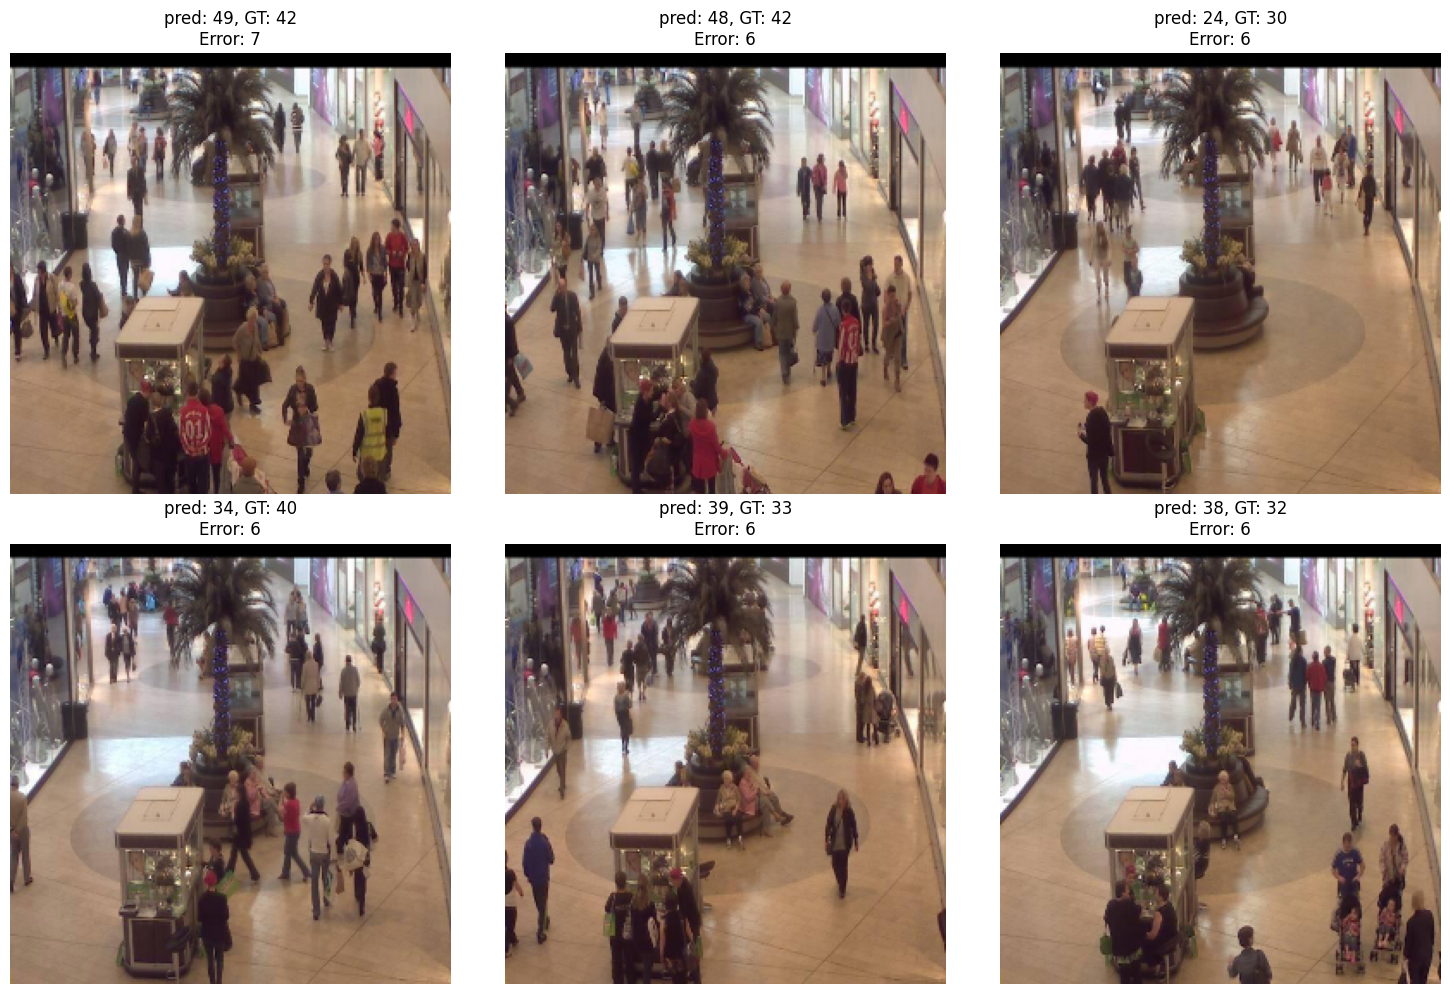

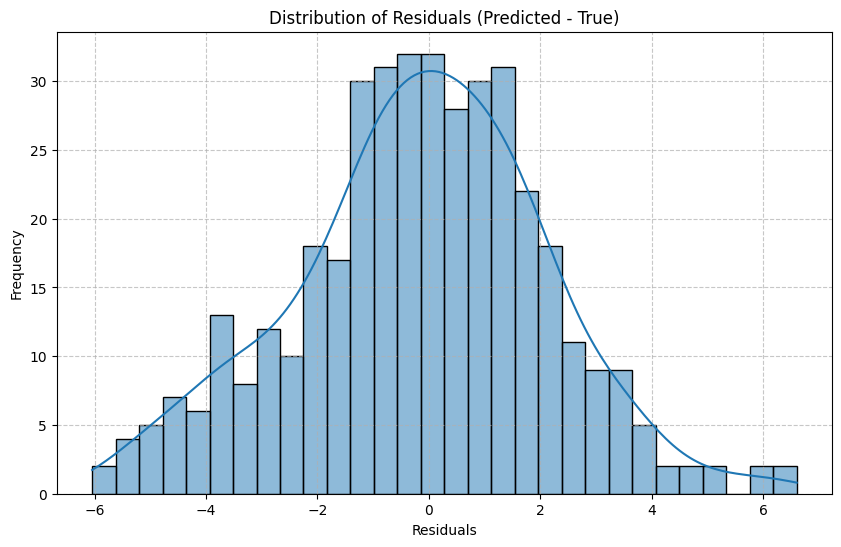

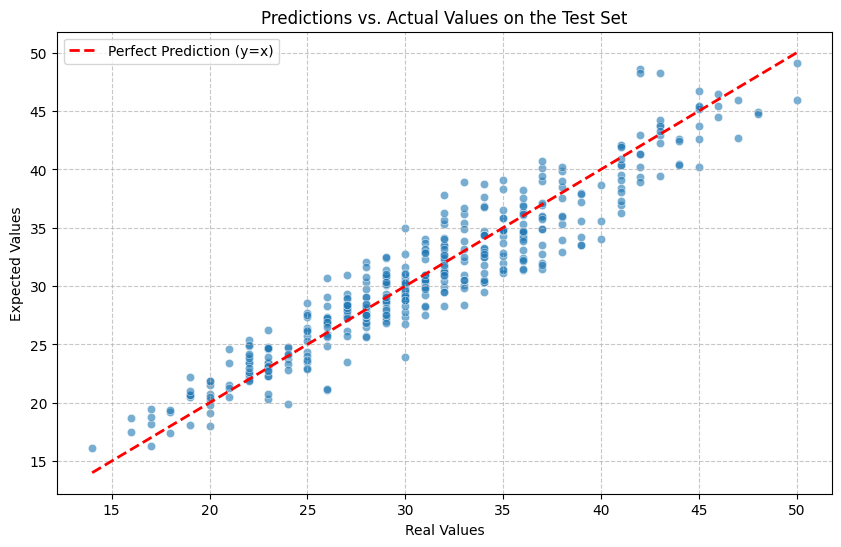

In [ ]:
test_dataset_optimized = CrowdCountLogDataset(x_test, y_test, transforms = val_transforms)
test_loader_optimized = DataLoader(test_dataset_optimized, batch_size = 16, shuffle = False, num_workers = 2, pin_memory = True)

@torch.no_grad()
def get_all_predictions_optimized(model, loader, device):
    model.eval()
    all_preds = []
    all_gts = []
    for imgs, log_counts in loader:
        imgs = imgs.to(device)
        preds_log = model(imgs)
        pred_counts = torch.expm1(preds_log).cpu().numpy()
        gt_counts = torch.expm1(log_counts).cpu().numpy()
        all_preds.extend(pred_counts)
        all_gts.extend(gt_counts)
    return np.array(all_preds), np.array(all_gts)


class ResNetLogRegressor(nn.Module):
    def __init__(self, pretrained = True):
        super().__init__()
        self.backbone = models.resnet18(weights = models.ResNet18_Weights.DEFAULT if pretrained else None)
        in_f = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.regressor = nn.Sequential(
            nn.Linear(in_f, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        feats = self.backbone(x)
        out = self.regressor(feats).squeeze(1)
        return out

CHECKPOINT_OPTIMIZED = "/kaggle/working/resnet_log_best.pth"
model_optimized = ResNetLogRegressor(pretrained = True).to(device)
ckpt_optimized = torch.load(CHECKPOINT_OPTIMIZED, map_location = device)
model_optimized.load_state_dict(ckpt_optimized['model_state_dict'])

preds_test_optimized, gts_test_optimized = get_all_predictions_optimized(model_optimized, test_loader_optimized, device)

print(f"umber of samples in the test set: {len(preds_test_optimized)}")
print(f"MAE on the test set: {np.mean(np.abs(preds_test_optimized - gts_test_optimized)):.4f}")

absolute_errors_optimized = np.abs(preds_test_optimized - gts_test_optimized)

worst_6_indices_optimized = np.argsort(absolute_errors_optimized)[-6:][::-1]

print("the 6 worst forecasts:")
for i, idx in enumerate(worst_6_indices_optimized):
    print(f"{i + 1}. sample index: {idx}, expected: {preds_test_optimized[idx]:.2f}, real: {gts_test_optimized[idx]:.2f}, error: {absolute_errors_optimized[idx]:.2f}")

plt.figure(figsize=(15, 10))
for i, idx in enumerate(worst_6_indices_optimized):
    plt.subplot(2, 3, i + 1)
    img_display = x_test[idx]
    plt.imshow(img_display)
    plt.title(f"pred: {preds_test_optimized[idx]:.0f}, GT: {gts_test_optimized[idx]:.0f}\nError: {absolute_errors_optimized[idx]:.0f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

residuals_optimized = preds_test_optimized - gts_test_optimized

plt.figure(figsize=(10, 6))
sns.histplot(residuals_optimized, bins = 30, kde = True)
plt.title('Distribution of Residuals (Predicted - True)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x = gts_test_optimized, y = preds_test_optimized, alpha = 0.6)
plt.plot([min(gts_test_optimized), max(gts_test_optimized)], [min(gts_test_optimized), max(gts_test_optimized)], 'r--', lw = 2, label = 'Perfect Prediction (y=x)')
plt.title('Predictions vs. Actual Values on the Test Set')
plt.xlabel('Real Values')
plt.ylabel('Expected Values')
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.legend()
plt.show()

Option 1 with

* Test-Time Augmentation (TTA): Averaging predictions over flips/crops → often reduces MAE.
* Robust loss: Use SmoothL1Loss (Huber) or Log-cosh instead of MSE (less sensitive to outliers).
* Weighted sampling/balancing for high-count images (prevents the network from overlearning the mean).
* Longer fine-tuning with lower LR (1e-5) + CosineWarmup

THIRD MODEL: has the ResNet-18 core, it introduces several "State-of-the-Art" (SOTA) training strategies designed to improve robustness and accuracy in crowd estimation.

1. Transfer Learning & Backbone
Unlike the previous iteration, this model leverages Transfer Learning. It uses a ResNet-18 backbone pre-trained on the ImageNet-1K dataset. By starting with pre-learned features (edges, textures, and shapes), the model converges much faster and achieves a deeper understanding of visual spatial patterns compared to training from scratch.

2. Class Imbalance Management (Weighted Sampling)
To address the common problem of data distribution in crowd counting—where low-count images often outnumber high-count images—this architecture implements a WeightedRandomSampler. The dataset is divided into frequency-based bins. Rare samples (images with very high crowd density) are assigned higher weights. This ensures that the model learns to count large crowds just as effectively as small ones, preventing a bias toward lower numbers.

 Test-Time Augmentation (TTA). The main idea behind TTA is to make predictions more robust by averaging results from multiple augmented versions of the same input image, rather than relying on a single prediction. This often leads to improved accuracy, especially reducing MAE

In [ ]:
NUM_EPOCHS = 80
BASE_LR = 1e-5
WARMUP_EPOCHS = 5
CHECKPOINT = "/kaggle/working/best_tta_weighted_smooth.pth"

# we use train_dataset, val_dataset, and test_dataset as the chunk above

# function to address class imbalance
def create_weighted_sampler(counts_array, num_bins = 6):
    bins = np.linspace(0, counts_array.max() + 1e-6, num = num_bins)
    bin_ids = np.digitize(counts_array, bins)
    freqs = np.bincount(bin_ids, minlength = bin_ids.max() + 1)
    weights_per_bin = 1.0 / (freqs + 1e-6)
    sample_weights = weights_per_bin[bin_ids]
    return sample_weights

sample_weights = create_weighted_sampler(y_train, num_bins = 6)
sampler = WeightedRandomSampler(weights = sample_weights, num_samples = len(sample_weights), replacement = True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler = sampler, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, pin_memory = True)

print("batches - train:", len(train_loader), "val:", len(val_loader), "test:", len(test_loader))

# same as before
class ResNetLogRegressor(nn.Module):
    def __init__(self, weights = None):
        super().__init__()
        self.backbone = models.resnet18(weights = weights)
        in_f = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.regressor = nn.Sequential(
            nn.Linear(in_f, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
        # initialize regressor layers
        for m in self.regressor:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        feats = self.backbone(x)
        out = self.regressor(feats).squeeze(1)
        return out

USE_PRETRAINED = True
weights_arg = models.ResNet18_Weights.DEFAULT if USE_PRETRAINED else None
model = ResNetLogRegressor(weights = weights_arg).to(device)
criterion = nn.SmoothL1Loss()  # L1 loss
optimizer = optim.Adam(model.parameters(), lr = BASE_LR, weight_decay = WEIGHT_DECAY) # adam

# dynamically adjusts the learning_rate during training
def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS:
        return float(epoch + 1) / float(max(1, WARMUP_EPOCHS)) # helps stabilize training at the beginning
    else:
        progress = float(epoch - WARMUP_EPOCHS) / float(max(1, NUM_EPOCHS - WARMUP_EPOCHS)) # compute how far along the training is after the warmup phase
        return 0.5 * (1.0 + np.cos(np.pi * progress)) # cosine annealing formula
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lr_lambda)


def compute_mae_from_log(preds_log_tensor, gt_log_tensor): # compute the MAE
    # preds_log_tensor, gt_log_tensor: torch tensors
    pred_counts = torch.expm1(preds_log_tensor)
    gt_counts = torch.expm1(gt_log_tensor)
    return torch.abs(pred_counts - gt_counts).mean().item()

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    nb = 0
    for imgs, log_counts in loader:
        imgs = imgs.to(device)
        log_counts = log_counts.to(device)
        optimizer.zero_grad()
        preds = model(imgs)  # pred in log space
        loss = criterion(preds, log_counts)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred_counts = torch.expm1(preds)
        gt_counts = torch.expm1(log_counts)
        mae = torch.abs(pred_counts - gt_counts).mean().item()
        running_mae += mae
        nb += 1
    return (running_loss/nb) if nb else 0.0, (running_mae/nb) if nb else 0.0

@torch.no_grad()
def tta_predict_batch(model, imgs): # make predictions more stable and accurate using TTA
    # imgs: tensor (B,C,H,W), normalized
    # produce predictions for multiple augmentations:
    # original, horizontal flip, center crop, 4 corner crops (all resized back)
    model.eval() # set the model in evaluation mode
    B, C, H, W = imgs.shape
    transforms = []

    # data augmentation
    transforms.append(imgs) # original imgs
    transforms.append(torch.flip(imgs, dims = [3]))  # horizontal flip

    # center crop
    crop_sz_h = int(0.9 * H)
    crop_sz_w = int(0.9 * W)
    y0 = (H - crop_sz_h) // 2
    x0 = (W - crop_sz_w) // 2
    center = imgs[:, :, y0: y0 + crop_sz_h, x0: x0 + crop_sz_w]
    center_resized = F.interpolate(center, size = (H, W), mode = 'bilinear', align_corners = False)
    transforms.append(center_resized)

    # four corner crops, slight variations of the input
    top_left = imgs[:, :, 0: crop_sz_h, 0: crop_sz_w]
    top_right = imgs[:, :, 0: crop_sz_h, W - crop_sz_w: W]
    bot_left = imgs[:, :, H - crop_sz_h: H, 0: crop_sz_w]
    bot_right = imgs[:, :, H - crop_sz_h: H, W - crop_sz_w: W]
    for crop in (top_left, top_right, bot_left, bot_right):
        transforms.append(F.interpolate(crop, size = (H, W), mode = 'bilinear', align_corners = False))

    # for each transform, predict and convert to counts in linear space, then average
    count_preds = []
    for t in transforms:
        t = t.to(device)
        out_log = model(t)
        out_count = torch.expm1(out_log).cpu() # prediction
        count_preds.append(out_count.numpy())

    # average across transforms
    avg_counts = np.mean(np.stack(count_preds, axis = 0), axis = 0)
    return avg_counts


@torch.no_grad()# disable gradient calculation
def evaluate_model(model, loader, use_tta = False):
    model.eval() # puts the model into validation mode
    running_mae = 0.0
    running_loss = 0.0
    nb = 0
    all_preds = []
    all_gts = []
    for imgs, log_counts in loader:
        if use_tta:
            preds_counts = tta_predict_batch(model, imgs)
            preds_log = torch.log1p(torch.from_numpy(preds_counts)).to(device)
        else:
            imgs = imgs.to(device)
            preds_log = model(imgs)
        log_counts = log_counts.to(device)
        loss = criterion(preds_log, log_counts).item() # compute loss in log space
        running_loss += loss

        mae_batch = compute_mae_from_log(preds_log, log_counts) if not use_tta else np.mean(np.abs(preds_counts - np.expm1(log_counts.cpu().numpy())))
        running_mae += mae_batch
        nb += 1

        # store
        if use_tta:
            all_preds.append(preds_counts)
            all_gts.append(np.expm1(log_counts.cpu().numpy()))
        else:
            all_preds.append(torch.expm1(preds_log).cpu().numpy())
            all_gts.append(np.expm1(log_counts.cpu().numpy()))

    mean_loss = running_loss / nb if nb else 0.0
    mean_mae = running_mae / nb if nb else 0.0
    all_preds = np.concatenate(all_preds) if all_preds else np.array([]) # concatenate arrays
    all_gts = np.concatenate(all_gts) if all_gts else np.array([])
    return mean_loss, mean_mae, all_preds, all_gts

# training phase
best_val_mae = float('inf')
history = []
start_time = datetime.now()

for epoch in range(NUM_EPOCHS):
    train_loss, train_mae = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_mae, _, _ = evaluate_model(model, val_loader, use_tta = True)
    scheduler.step()

    history.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_mae': train_mae,
                    'val_loss': val_loss, 'val_mae': val_mae,
                    'lr': optimizer.param_groups[0]['lr']})

    print(f"epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"train Loss: {train_loss:.6f}, train MAE: {train_mae:.4f} | "
          f"val Loss: {val_loss:.6f}, val MAE: {val_mae:.4f}")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(
            {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_mae': val_mae,
            'history': history
        }, CHECKPOINT)
        print("Saved best model to", CHECKPOINT) # save the model with the best mae

end_time = datetime.now()
print("Training finished - duration:", end_time - start_time)

ckpt = torch.load(CHECKPOINT, map_location = device, weights_only=False) # Fix: Added weights_only=False
model.load_state_dict(ckpt['model_state_dict'])
print("Loaded checkpoint with val_mae =", ckpt.get('val_mae'))

test_loss, test_mae, preds_test, gts_test = evaluate_model(model, test_loader, use_tta = True)
print(f"test Loss: {test_loss:.6f}, test MAE: {test_mae:.4f}")

# print some sample predictions
for i in range(min(32, len(preds_test))):
    print(f"sample {i}: pred = {preds_test[i]:.2f}, GT = {gts_test[i]:.2f}")

pd.DataFrame(history).to_csv("/kaggle/working/training_history_tta_weighted_smooth.csv", index = False)
print("Saved training history to /kaggle/working/training_history_tta_weighted_smooth.csv")

batches - train: 85 val: 15 test: 25
epoch [1/80] train Loss: 4.125446, train MAE: 32.5914 | val Loss: 3.974031, val MAE: 31.7673
Saved best model to /kaggle/working/best_tta_weighted_smooth.pth
epoch [2/80] train Loss: 3.391769, train MAE: 32.1258 | val Loss: 2.970047, val MAE: 31.1162
Saved best model to /kaggle/working/best_tta_weighted_smooth.pth
epoch [3/80] train Loss: 2.147761, train MAE: 28.9554 | val Loss: 1.412992, val MAE: 27.2883
Saved best model to /kaggle/working/best_tta_weighted_smooth.pth
epoch [4/80] train Loss: 0.724176, train MAE: 23.9244 | val Loss: 0.072374, val MAE: 8.5983
Saved best model to /kaggle/working/best_tta_weighted_smooth.pth
epoch [5/80] train Loss: 0.376657, train MAE: 27.3541 | val Loss: 0.045327, val MAE: 8.9601
epoch [6/80] train Loss: 0.306911, train MAE: 25.6305 | val Loss: 0.028331, val MAE: 6.3631
Saved best model to /kaggle/working/best_tta_weighted_smooth.pth
epoch [7/80] train Loss: 0.303641, train MAE: 24.4861 | val Loss: 0.023174, val MAE

FOURTH MODEL: PET Quadtree
(https://www.youtube.com/watch?v=XLIfuknG2tc)

In [ ]:
BATCH_SIZE = 4
NUM_EPOCHS = 20
PRINT_EVERY = 10

INITIAL_STRIDE = 64  # parent cell size in pixels (level0)
NUM_LEVELS = 2
LOCAL_WINDOW_PX = 48  # crop window in pixels (original image units)
TRANSFORMER_DIM = 256
NUM_DECODER_LAYERS = 2
NUM_HEADS = 4

CLS_WEIGHT = 1.0
L1_WEIGHT = 5.0
SPLIT_WEIGHT = 1.0


class CrowdPointsDataset(Dataset):
    def __init__(self, images: np.ndarray, counts: np.ndarray, points_df: Optional[pd.DataFrame] = None,
                 target_size: Tuple[int,int] = TARGET_IMG_SIZE, transforms = None):
        assert len(images) == len(counts)
        self.images = images
        self.counts = counts.astype(np.int32)
        self.target_size = target_size
        self.transforms = transforms
        self.N = images.shape[0]
        Ht, Wt = target_size # image height and width for point normalization logic

        # prepare per-image gt points
        self.points_per_image = [None] * self.N # initialize a list
        if points_df is not None: # if exact locations are provided
            for i in range(self.N):
                rows = points_df[points_df['id'] == i]
                if rows.shape[0] == 0:
                    self.points_per_image[i] = np.zeros((0,2), dtype = np.float32)
                else:
                    pts = rows[['x','y']].values.astype(np.float32)
                    self.points_per_image[i] = pts.copy()
        else:
            # generate uniform random points per image (weak supervision)
            for i in range(self.N):
                c = int(self.counts[i])
                if c <= 0:
                    self.points_per_image[i] = np.zeros((0,2), dtype = np.float32)
                else:
                    xs = np.random.uniform(0, Wt, size = (c,))
                    ys = np.random.uniform(0, Ht, size = (c,))
                    pts = np.stack([xs, ys], axis = 1).astype(np.float32)
                    self.points_per_image[i] = pts

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transforms is not None:
            img_t = self.transforms(img)
        else:
            img_t = T.ToTensor()(img)
        pts = self.points_per_image[idx].copy()  # Nx2 pixel coords
        # normalized coords in [0,1]
        Ht, Wt = self.target_size
        if pts.shape[0] > 0:
            pts_norm = pts.copy()
            pts_norm[:,0] = pts[:, 0] / float(Wt)
            pts_norm[:,1] = pts[:, 1] / float(Ht) # normalize the coordinate
        else:
            pts_norm = pts.reshape(0,2)
        return img_t, torch.from_numpy(pts_norm).float(), float(self.counts[idx])

def collate_fn(batch):
    imgs = torch.stack([b[0] for b in batch], dim = 0)
    pts = [b[1] for b in batch]  # list of tensors (Ni, 2)
    counts = torch.tensor([b[2] for b in batch], dtype = torch.float32)
    return imgs, pts, counts

# cnn backbone
class CNNBackbone(nn.Module):
    def __init__(self, pretrained = False, out_dim = TRANSFORMER_DIM):
        super().__init__()
        self.resnet = models.resnet18(weights = None if not pretrained else models.ResNet18_Weights.DEFAULT)
        self.conv1 = self.resnet.conv1
        self.bn1 = self.resnet.bn1
        self.relu = self.resnet.relu
        self.maxpool = self.resnet.maxpool
        self.layer1 = self.resnet.layer1
        self.layer2 = self.resnet.layer2
        self.layer3 = self.resnet.layer3
        self.proj = nn.Conv2d(256, out_dim, kernel_size = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        feat = self.layer3(x)
        feat = self.proj(feat)
        return feat

# quadtree splitter
class QuadtreeSplitter(nn.Module):
    def __init__(self, in_channels:int, img_size:Tuple[int, int], initial_stride:int = INITIAL_STRIDE):
        super().__init__()
        self.in_channels = in_channels
        self.img_size = img_size
        self.k = initial_stride
        self.split_head = nn.Sequential(
            nn.Linear(in_channels, in_channels // 2),
            nn.ReLU(inplace = True),
            nn.Linear(in_channels // 2, 1)
        )

    def _level0_centers(self):
        H, W = self.img_size
        k = self.k
        xs = np.arange(k/2, W, k)
        ys = np.arange(k/2, H, k)
        centers = []
        for y in ys:
            for x in xs:
                centers.append((x,y))
        centers = np.array(centers, dtype=np.float32)
        return centers  # (M,2) in pixel coords

    def forward(self, feat: torch.Tensor):
        B, C, Hf, Wf = feat.shape # extract the dim
        device = feat.device
        img_H, img_W = self.img_size # extract height and width
        parents = self._level0_centers() # generates the pixel coordinates of the centers of the initial parent cells
        M = parents.shape[0]

        # convert the pixel coordinates of the centers of the parent cells to integer coordinates within the feature map
        fx = (parents[:,0] / float(img_W) * (Wf - 1)).astype(int)
        fy = (parents[:,1] / float(img_H) * (Hf - 1)).astype(int)

        pad = 1 # padding = 1
        feat_p = F.pad(feat, (pad, pad, pad, pad), mode = 'reflect')  # padding with respect to B, C, Hf + 2, Hf + 2
        pooled = []
        for b in range(B):
            samples = []
            for (xpix, ypix), fx_i, fy_i in zip(parents, fx, fy):
                sx = fx_i + pad
                sy = fy_i + pad # calculate the coordinates of the cell center
                patch = feat_p[b:b + 1, :, sy - pad:sy + pad + 1, sx - pad:sx + pad + 1] # extracts a 3x3 from the tensor
                samples.append(patch.mean(dim = [2, 3]).squeeze(0))
            samples = torch.stack(samples, dim = 0)
            pooled.append(samples)
        pooled = torch.stack(pooled, dim = 0) # tensor
        # compute split logits B,M
        split_logits = self.split_head(pooled) # MLP with dim B, M, 1
        split_logits = split_logits.squeeze(-1)

        # now build per-image child centers: if split -> 4 subcells else keep parent
        queries_per_image = []
        for b in range(B):
            mask = (torch.sigmoid(split_logits[b]) > 0.5).cpu().numpy()  # apply a sigmoid function to the logits
            child_centers = []
            child_sizes = []
            for m_idx, do_split in enumerate(mask):
                px, py = parents[m_idx]
                size_parent = float(self.k)
                if do_split: # if the parent cell needs to be split the code calculates the coordinates of the four centers of its child cells
                    half = size_parent / 2.0
                    offs = [(-half / 2, -half / 2), (half / 2, -half / 2), (-half / 2, half / 2), (half / 2, half / 2)]
                    for dx, dy in offs:
                        cx = px + dx
                        cy = py + dy
                        if 0 <= cx < img_W and 0 <= cy < img_H:
                            child_centers.append((cx, cy))
                            child_sizes.append(size_parent / 2.0)
                else:
                    child_centers.append((px, py))
                    child_sizes.append(size_parent)
            if len(child_centers) == 0:
                q_centers = np.zeros((0, 2), dtype = np.float32)
                q_sizes = np.zeros((0, ), dtype = np.float32)
            else:
                q_centers = np.array(child_centers, dtype = np.float32)  # pixel coords
                q_sizes = np.array(child_sizes, dtype = np.float32)
                # normalize centers to [0,1]
                q_centers[:, 0] = q_centers[:, 0] / float(img_W)
                q_centers[:, 1] = q_centers[:, 1] / float(img_H)
                q_sizes = q_sizes / float(max(img_W, img_H))
            # also include parent centers in pixel coords for split supervision
            queries_per_image.append({'parent_centers_pix': parents.copy(), 'child_centers_norm': q_centers, 'child_sizes_norm': q_sizes})
        return queries_per_image, split_logits

# takes the global feature map extracted from the CNN backbone and cuts out small windows around the points of interest summarizing the information
def sample_local_windows_simple(feat: torch.Tensor, centers_norm_list: List[np.ndarray], window_px: int, img_size: Tuple[int,int]):
    B, C, Hf, Wf = feat.shape
    Himg, Wimg = img_size
    out = []
    for b in range(B):
        centers = centers_norm_list[b]  # list where each array contains the normalized coordinates
        if centers.shape[0] == 0: # if the current image has no centers an empty tensor is added
            out.append(torch.zeros((0, C), device = feat.device))
            continue
        tokens = []
        for (cx, cy) in centers:
            # map to feature coords
            fx = int(round(cx * (Wf-1)))
            fy = int(round(cy * (Hf-1)))
            # radius in feature coords
            rad_x = max(1, int(round((window_px / float(Wimg)) * Wf / 2.0)))
            rad_y = max(1, int(round((window_px / float(Himg)) * Hf / 2.0)))
            x0 = max(0, fx - rad_x)
            x1 = min(Wf, fx + rad_x + 1)
            y0 = max(0, fy - rad_y)
            y1 = min(Hf, fy + rad_y + 1)
            patch = feat[b: b + 1, :, y0: y1, x0: x1] # extracts a portion of the global feature map for the current image
            if patch.numel() == 0: # if the extracted patch is empty, a vector of zeros is added.
                pooled = torch.zeros((C,), device = feat.device)
            else:
                pooled = F.adaptive_avg_pool2d(patch, (1, 1)).view(C)
            tokens.append(pooled)
        tokens = torch.stack(tokens, dim = 0)
        out.append(tokens)
    return out

# implements the transformer decoder
class PointQueryDecoder(nn.Module):
    def __init__(self, d_model = TRANSFORMER_DIM, nhead = NUM_HEADS, num_layers = 2):
        super().__init__()
        # create one layer
        layer = nn.TransformerDecoderLayer(d_model = d_model, nhead = nhead, dim_feedforward = 4 * d_model, dropout = 0.1, activation = 'relu')
        self.decoder = nn.TransformerDecoder(layer, num_layers = num_layers) # builds the entire decoder
        self.init_proj = nn.Linear(d_model, d_model) # initializes a linear layer for a possible initial query projection

    # forward pass
    def forward(self, tgt: torch.Tensor, memory: torch.Tensor, tgt_key_padding_mask = None):
        out = self.decoder(tgt = tgt, memory = memory, tgt_key_padding_mask = tgt_key_padding_mask)
        return out # the decoder processes the queries tgt using global features memory to produce an output

# final prediction
class PredictionHead(nn.Module):
    def __init__(self, d_model = TRANSFORMER_DIM):
        super().__init__()
        self.cls = nn.Linear(d_model, 1)   # logits
        self.reg = nn.Linear(d_model, 2)   # offsets (normalized)
    def forward(self, q):
        logits = self.cls(q).squeeze(-1)   # (T,B)
        offsets = torch.tanh(self.reg(q)) * 0.05 # apply the regression layer to q to get the offsets.
        return logits, offsets

# hungarian matcher
# optimally matches model predictions to true ground truths
def hungarian_match(pred_probs: np.ndarray, pred_coords: np.ndarray, gt_coords: np.ndarray, cls_cost = 1.0, l1_cost = 5.0):
    if gt_coords.shape[0] == 0 or pred_coords.shape[0] == 0: # handles empty cases
        return np.array([], dtype = int), np.array([], dtype = int)
    Np = pred_coords.shape[0]
    Ng = gt_coords.shape[0]
    # compute the cost matrix Ng x Np in order to minimize it
    l1 = np.linalg.norm(pred_coords[None,:,:] - gt_coords[:,None,:], ord = 1, axis = 2)
    cls_cost_mat = - (pred_probs[None,:].repeat(Ng, axis = 0))  # want high prob -> low cost
    cost = cls_cost_mat * cls_cost + l1 * l1_cost
    row_ind, col_ind = linear_sum_assignment(cost)
    return col_ind, row_ind

# PET model
class PETQuadtreeModel(nn.Module):
    def __init__(self, img_size = TARGET_IMG_SIZE, pretrained_backbone = False):
        super().__init__()
        self.img_size = img_size
        self.backbone = CNNBackbone(pretrained = pretrained_backbone, out_dim = TRANSFORMER_DIM) # initialize the backbone
        # this component analyzes the features extracted from the backbone and decides how to divide the image into regions.
        self.splitter = QuadtreeSplitter(in_channels = TRANSFORMER_DIM, img_size = img_size, initial_stride = INITIAL_STRIDE)
        self.decoder = PointQueryDecoder(d_model = TRANSFORMER_DIM)
        self.pred_head = PredictionHead(d_model = TRANSFORMER_DIM)
        self.pool_proj = nn.Linear(TRANSFORMER_DIM, TRANSFORMER_DIM)

    def forward(self, images: torch.Tensor):
        B = images.size(0)
        feat = self.backbone(images)  # B, D, Hf, Wf
        queries_per_image, split_logits = self.splitter(feat)  # list length B tensor (B,M)
        centers_list = [q['child_centers_norm'] for q in queries_per_image] # extracts normalized center lists from queries_per_image for each image
        local_tokens = sample_local_windows_simple(feat, centers_list, LOCAL_WINDOW_PX, self.img_size)
        num_queries_per_image = [t.shape[0] for t in centers_list] # compute the number of query
        Kmax = max(num_queries_per_image) if len(num_queries_per_image)>0 else 0 # determines the maximum number of queries across all images in the batch
        if Kmax == 0:
            preds = [{'centers': np.zeros((0, 2)), 'scores': np.zeros((0,)), 'offsets': np.zeros((0, 2))} for _ in range(B)]
            return {'preds': preds, 'split_logits': split_logits}
        # build tgt (T,B,D)
        tgt = feat.new_zeros((Kmax, B, TRANSFORMER_DIM))
        tgt_mask = torch.ones((B, Kmax), dtype = torch.bool, device = feat.device)  # true = padding
        for b in range(B):
            k = num_queries_per_image[b]
            if k > 0:
                emb = self.pool_proj(local_tokens[b].to(feat.device))  # local_tokens of the current image are passed through the self.pool_proj linear layer for a projection
                tgt[:k, b, :] = emb
                tgt_mask[b, :k] = False
            else:
                tgt[:, b, :] = 0.0
                tgt_mask[b, :] = True
        # memory is flattened feature map
        Bf, C, Hf, Wf = feat.shape
        memory = feat.view(B, C, Hf * Wf).permute(2, 0, 1)
        decoded = self.decoder(tgt, memory, tgt_key_padding_mask = tgt_mask) # (T,B,D)
        logits, offsets = self.pred_head(decoded) # (T,B), (T,B,2)
        # build preds list
        preds = []
        for b in range(B):
            k = num_queries_per_image[b]
            if k == 0:
                preds.append({'centers': np.zeros((0, 2)), 'scores': np.zeros((0,)), 'offsets': np.zeros((0, 2))})
                continue
            centers = queries_per_image[b]['child_centers_norm']  # K,2
            # apply offsets: offsets are small normalized deltas
            offs = offsets[:k, b].detach().cpu().numpy()
            coords = centers.copy()
            coords = coords + offs  # may go out of [0,1]
            coords = np.clip(coords, 0.0, 1.0)
            scores = torch.sigmoid(logits[:k, b].detach()).cpu().numpy()
            preds.append({'centers': coords, 'scores': scores, 'offsets': offs, 'logits': logits[:k, b]})
        return {'preds': preds, 'split_logits': split_logits}

bce_logits = nn.BCEWithLogitsLoss()

def compute_split_targets_for_image(parent_centers_pix: np.ndarray, gt_pts_norm: np.ndarray, img_size: Tuple[int,int], k_parent:int):
    H, W = img_size
    Ng = gt_pts_norm.shape[0]
    if Ng == 0:
        return np.zeros((parent_centers_pix.shape[0],), dtype = np.float32)
    gt_pix = gt_pts_norm.copy()
    gt_pix[:,0] *= W
    gt_pix[:,1] *= H
    half = k_parent / 2.0
    x0s = parent_centers_pix[:, 0] - half
    x1s = parent_centers_pix[:, 0] + half
    y0s = parent_centers_pix[:, 1] - half
    y1s = parent_centers_pix[:, 1] + half

    targets = np.zeros((parent_centers_pix.shape[0],), dtype = np.float32)
    for i in range(parent_centers_pix.shape[0]):
        # efficient check if any gt_pix point is within the current cell bounds
        inside = ((gt_pix[:, 0] >= x0s[i]) & (gt_pix[:, 0] < x1s[i]) &
                  (gt_pix[:, 1] >= y0s[i]) & (gt_pix[:, 1] < y1s[i]))
        if np.sum(inside) >= 2:
            targets[i] = 1.0
    return targets

# training loop
def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    total_loss = 0.0
    total_cls_loss = 0.0
    total_l1_loss = 0.0
    total_split_loss = 0.0
    it = 0
    for bi, (imgs, pts_list, counts) in enumerate(loader):
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs['preds'] # list length B
        split_logits = outputs['split_logits']
        B = imgs.size(0)
        loss_total_batch = 0.0

        for b in range(B):
            pred = preds[b]
            pred_coords = pred['centers']
            pred_scores = pred['scores']
            logits_tensor = pred['logits']
            gt = pts_list[b].numpy()
            Kb = pred_coords.shape[0]

            # form classification targets via hungarian matching
            if Kb == 0 and gt.shape[0] == 0:
                # no predictions and no ground truth, no loss contribution
                cls_loss = torch.tensor(0.0, device = device)
                l1 = torch.tensor(0.0, device = device)
            elif Kb == 0 and gt.shape[0] > 0:
                # no predictions but there is ground truth penalize with negative class logit for all GT points
                cls_loss = torch.tensor(1.0, device = device) # represents a high cost for missed detections
                l1 = torch.tensor(0.0, device = device)
            elif Kb > 0 and gt.shape[0] == 0:
                # predictions but no ground truth, penalize all predictions as false positives
                targets = torch.zeros_like(logits_tensor)
                cls_loss = bce_logits(logits_tensor, targets)
                l1 = torch.tensor(0.0, device = device)
            else: # Kb > 0 and gt.shape[0] > 0
                # matching
                col_idx, row_idx = hungarian_match(pred_scores, pred_coords, gt, cls_cost = 1.0, l1_cost = 5.0)

                # classification target: 1 for matched preds, else 0
                targets = torch.zeros((Kb,), dtype = torch.float32, device = device)
                if col_idx.size > 0:
                    targets[col_idx] = 1.0
                cls_loss = bce_logits(logits_tensor, targets)

                # localization loss for matched pairs
                if col_idx.size > 0:
                    pcoords = torch.from_numpy(pred_coords[col_idx]).to(device).float()
                    gcoords = torch.from_numpy(gt[row_idx]).to(device).float()
                    l1 = F.smooth_l1_loss(pcoords, gcoords)
                else:
                    l1 = torch.tensor(0.0, device = device)

            # split supervision: compute parent targets from model parent centers
            parent_centers_pix = model.splitter._level0_centers() # (M,2)
            split_targets = compute_split_targets_for_image(parent_centers_pix, gt, model.img_size, model.splitter.k)
            split_targets_t = torch.from_numpy(split_targets).to(device).float()
            split_logits_b = split_logits[b]
            split_loss = bce_logits(split_logits_b, split_targets_t)

            # accumulate weighted
            loss_img = CLS_WEIGHT * cls_loss + L1_WEIGHT * l1 + SPLIT_WEIGHT * split_loss
            loss_total_batch = loss_total_batch + loss_img

            total_cls_loss += (CLS_WEIGHT * cls_loss.item())
            total_l1_loss += (L1_WEIGHT * l1.item())
            total_split_loss += (SPLIT_WEIGHT * split_loss.item())

        optimizer.zero_grad()
        loss_total_batch.backward()
        optimizer.step()
        total_loss += float(loss_total_batch.detach().item())
        it += 1
        if bi % PRINT_EVERY == 0:
            print(f"epoch {epoch} batch {bi} loss {loss_total_batch.item():.4f} (cls {CLS_WEIGHT * cls_loss.item():.4f} l1 {L1_WEIGHT * l1.item():.4f} split {SPLIT_WEIGHT * split_loss.item():.4f})")

    avg_loss = total_loss / max(1, it)
    avg_cls_loss = total_cls_loss / max(1, it)
    avg_l1_loss = total_l1_loss / max(1, it)
    avg_split_loss = total_split_loss / max(1, it)

    return avg_loss, avg_cls_loss, avg_l1_loss, avg_split_loss

@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    mae_sum = 0.0
    n = 0
    for imgs, pts_list, counts in loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs['preds']
        B = imgs.size(0)
        for b in range(B):
            pred = preds[b]
            pred_scores = pred['scores']
            # predicted count = sum prob > 0.5
            pc = int((pred_scores > 0.5).sum())
            gt = int(counts[b].item())
            mae_sum += abs(pc - gt)
            n += 1
    return mae_sum / max(1, n)

# transforms
train_t = T.Compose([T.ToPILImage(), T.RandomResizedCrop(TARGET_IMG_SIZE, scale = (0.7, 1.0)),
                     T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize(mean = imagenet_mean, std = imagenet_std)])
val_t = T.Compose([T.ToPILImage(), T.Resize(TARGET_IMG_SIZE), T.ToTensor(),
                   T.Normalize(mean = imagenet_mean, std = imagenet_std)])

ds = CrowdPointsDataset(images, counts, points_df = None, target_size = TARGET_IMG_SIZE, transforms = train_t)
N = len(ds)
idx = np.arange(N)
tr_idx, te_idx = train_test_split(idx, test_size = 0.2, random_state = RANDOM_SEED)
tr_idx, val_idx = train_test_split(tr_idx, test_size = 0.15, random_state = RANDOM_SEED)
train_ds = torch.utils.data.Subset(ds, tr_idx)
val_ds = torch.utils.data.Subset(ds, val_idx)
test_ds = torch.utils.data.Subset(ds, te_idx)

train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2, collate_fn = collate_fn, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, collate_fn = collate_fn, pin_memory = True)
test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, collate_fn = collate_fn, pin_memory = True)

model = PETQuadtreeModel(img_size = TARGET_IMG_SIZE, pretrained_backbone = False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

best_val = float('inf')
for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss, tr_cls_loss, tr_l1_loss, tr_split_loss = train_one_epoch(model, train_loader, optimizer, epoch)
    val_mae = evaluate_model(model, val_loader)
    print(f"epoch {epoch} trainLoss {tr_loss:.4f} (cls {tr_cls_loss:.4f} l1 {tr_l1_loss:.4f} split {tr_split_loss:.4f}) MAE {val_mae:.4f}")
    state = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'val_mae': float(val_mae)}
    ckpt = f"/kaggle/working/pet_quadtree_epoch{epoch}.pth"
    torch.save(state, ckpt)
    if val_mae < best_val:
        best_val = val_mae
        torch.save({'model_state_dict': model.state_dict(), 'val_mae': float(val_mae)}, "/kaggle/working/pet_quadtree_best.pth")
        print("Saved best model.")


best = torch.load("/kaggle/working/pet_quadtree_best.pth", map_location = device)
model.load_state_dict(best['model_state_dict'])
test_mae = evaluate_model(model, test_loader)
print("Final test MAE:", test_mae)

epoch 1 batch 0 loss 7.1629 (cls 1.1305 l1 0.0209 split 0.7015)
epoch 1 batch 10 loss 12.5144 (cls 2.0453 l1 0.0037 split 0.6871)
epoch 1 batch 20 loss 6.3052 (cls 0.8760 l1 0.0044 split 0.6359)
epoch 1 batch 30 loss 5.5561 (cls 0.6950 l1 0.0045 split 0.6464)
epoch 1 batch 40 loss 5.6221 (cls 0.7118 l1 0.0053 split 0.6970)
epoch 1 batch 50 loss 5.5371 (cls 0.7279 l1 0.0064 split 0.6217)
epoch 1 batch 60 loss 5.4761 (cls 0.6847 l1 0.0049 split 0.6686)
epoch 1 batch 70 loss 5.8161 (cls 0.7133 l1 0.0076 split 0.7338)
epoch 1 batch 80 loss 5.4811 (cls 0.7084 l1 0.0048 split 0.6512)
epoch 1 batch 90 loss 5.6871 (cls 0.6947 l1 0.0051 split 0.6902)
epoch 1 batch 100 loss 5.4375 (cls 0.6895 l1 0.0043 split 0.6937)
epoch 1 batch 110 loss 5.6096 (cls 0.7049 l1 0.0046 split 0.6777)
epoch 1 batch 120 loss 5.4181 (cls 0.6920 l1 0.0055 split 0.6561)
epoch 1 batch 130 loss 5.5327 (cls 0.7686 l1 0.0081 split 0.6808)
epoch 1 batch 140 loss 5.5844 (cls 0.6891 l1 0.0049 split 0.6677)
epoch 1 batch 150 lo

PET with some change in terms of parameters

In [ ]:
PRINT_EVERY = 20 # frequency of printing during training

SPLIT_THRESHOLD = 0.3
NUM_HEADS = 4

USE_PRETRAINED_BACKBONE = True

# same as before
class CrowdPointsDataset(Dataset):
    def __init__(self, images: np.ndarray, counts: np.ndarray, points_df: Optional[pd.DataFrame] = None,
                 target_size: Tuple[int, int] = TARGET_IMG_SIZE, transforms = None):
        assert len(images) == len(counts)
        self.images = images
        self.counts = counts.astype(np.int32)
        self.target_size = target_size
        self.transforms = transforms
        self.N = images.shape[0]

        self.points_per_image = [None] * self.N
        if points_df is not None:
            for i in range(self.N):
                rows = points_df[points_df['id'] == i]
                self.points_per_image[i] = rows[['x','y']].values.astype(np.float32) if rows.shape[0] > 0 else np.zeros((0,2), dtype = np.float32)
        else:
            # if no specific points_df generate random points based on count for weak supervision
            # this assumes points are randomly distributed within the image size given initial count
            Ht, Wt = self.target_size
            for i in range(self.N):
                c = int(self.counts[i])
                pts = np.random.uniform(0, Wt, size = (c, 2)).astype(np.float32) if c > 0 else np.zeros((0, 2), dtype = np.float32)
                self.points_per_image[i] = pts

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        img = self.images[idx]
        img_t = self.transforms(img) if self.transforms is not None else T.ToTensor()(img)
        pts = self.points_per_image[idx].copy()
        Ht, Wt = self.target_size
        pts_norm = pts / np.array([Wt, Ht], dtype = np.float32) if pts.shape[0] > 0 else pts.reshape(0,2)
        return img_t, torch.from_numpy(pts_norm).float(), float(self.counts[idx])

def collate_fn(batch):
    imgs = torch.stack([b[0] for b in batch], dim = 0)
    pts = [b[1] for b in batch]
    counts = torch.tensor([b[2] for b in batch], dtype = torch.float32)
    return imgs, pts, counts

class CNNBackbone(nn.Module):
    def __init__(self, pretrained = USE_PRETRAINED_BACKBONE, out_dim = TRANSFORMER_DIM):
        super().__init__()
        res = models.resnet18(weights = models.ResNet18_Weights.DEFAULT if pretrained else None)
        self.features = nn.Sequential(res.conv1, res.bn1, res.relu, res.maxpool, res.layer1, res.layer2, res.layer3)
        self.proj = nn.Conv2d(256, out_dim, kernel_size = 1)
    def forward(self, x): return self.proj(self.features(x))

class QuadtreeSplitter(nn.Module):
    def __init__(self, in_channels:int, img_size:Tuple[int, int], initial_stride:int = INITIAL_STRIDE, split_threshold:float = SPLIT_THRESHOLD):
        super().__init__()
        self.img_size, self.k, self.split_threshold = img_size, initial_stride, split_threshold
        self.split_head = nn.Sequential(nn.Linear(in_channels, in_channels // 2), nn.ReLU(inplace = True), nn.Linear(in_channels // 2, 1))

    def _level0_centers(self):
        H, W = self.img_size
        xs, ys = np.arange(self.k / 2, W, self.k), np.arange(self.k / 2, H, self.k)
        return np.array([(x,y) for y in ys for x in xs], dtype = np.float32)

    def forward(self, feat: torch.Tensor):
        B, C, Hf, Wf = feat.shape
        img_H, img_W = self.img_size
        parents = self._level0_centers()
        fx = (parents[:, 0] / img_W * (Wf - 1)).astype(int)
        fy = (parents[:, 1] / img_H * (Hf - 1)).astype(int)
        feat_p = F.pad(feat, (1, 1, 1, 1), mode = 'reflect')
        pooled = torch.stack([torch.stack([feat_p[b, :, r:r + 3, c:c + 3].mean(dim = [1,2]) for c, r in zip(fx, fy)]) for b in range(B)])
        split_logits = self.split_head(pooled).squeeze(-1)
        queries_per_image = []
        for b in range(B):
            mask = (torch.sigmoid(split_logits[b]) > self.split_threshold).cpu().numpy()
            c_centers = []
            for m_idx, do_split in enumerate(mask):
                px, py = parents[m_idx]
                if do_split:
                    half = self.k / 4.0
                    for dx, dy in [(-half, -half), (half, -half), (-half, half), (half, half)]:
                        c_centers.append((px + dx, py + dy))
                else:
                    c_centers.append((px, py))
            q_centers = np.array(c_centers, dtype = np.float32) / np.array([img_W, img_H], dtype = np.float32) if c_centers else np.zeros((0,2), dtype = np.float32)
            queries_per_image.append({'child_centers_norm': q_centers})
        return queries_per_image, split_logits

class PointQueryDecoder(nn.Module):
    def __init__(self, d_model = TRANSFORMER_DIM, nhead = NUM_HEADS, num_layers = 2):
        super().__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model = d_model, nhead = nhead, dim_feedforward = 4 * d_model, dropout = 0.1, batch_first = False)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers = num_layers)
    def forward(self, tgt, memory, tgt_key_padding_mask = None):
        return self.decoder(tgt = tgt, memory = memory, tgt_key_padding_mask = tgt_key_padding_mask)

class PETQuadtreeModel(nn.Module):
    def __init__(self, img_size = TARGET_IMG_SIZE, pretrained_backbone = USE_PRETRAINED_BACKBONE, initial_stride = INITIAL_STRIDE, split_threshold = SPLIT_THRESHOLD):
        super().__init__()
        self.img_size = img_size
        self.backbone = CNNBackbone(pretrained = pretrained_backbone)
        self.splitter = QuadtreeSplitter(TRANSFORMER_DIM, img_size, initial_stride, split_threshold)
        self.decoder = PointQueryDecoder()
        self.cls_head = nn.Linear(TRANSFORMER_DIM, 1)

    def forward(self, images):
        B = images.size(0)
        feat = self.backbone(images)
        queries, split_logits = self.splitter(feat)
        centers_list = [q['child_centers_norm'] for q in queries]
        Kmax = max([len(c) for c in centers_list]) if centers_list else 0
        if Kmax == 0: return {'preds': [{'scores': np.array([]), 'logits': torch.tensor([], device=device)} for _ in range(B)], 'split_logits': split_logits}

        tgt = feat.new_zeros((Kmax, B, TRANSFORMER_DIM))
        tgt_mask = torch.ones((B, Kmax), dtype = torch.bool, device = device)
        for b in range(B):
            k = len(centers_list[b])
            if k > 0:
                grid = torch.from_numpy(centers_list[b]).view(1, k, 1, 2).to(device).float() * 2 - 1
                # ensure feat type matches for grid_sample. Assuming feat is float.
                samp = F.grid_sample(feat[b:b+1].float(), grid, align_corners = True)
                samp = samp.view(TRANSFORMER_DIM, k).permute(1, 0)
                tgt[:k, b, :] = samp
                tgt_mask[b, :k] = False
        memory = feat.view(B, TRANSFORMER_DIM, -1).permute(2, 0, 1)
        decoded = self.decoder(tgt, memory, tgt_key_padding_mask = tgt_mask)
        logits = self.cls_head(decoded).squeeze(-1)
        preds = []
        for b in range(B):
            k = len(centers_list[b])
            l_slice = logits[:k, b] if k > 0 else torch.tensor([], device = device)
            preds.append({'scores': torch.sigmoid(l_slice).detach().cpu().numpy(), 'logits': l_slice})
        return {'preds': preds, 'split_logits': split_logits}

def hungarian_match(pred_probs, gt_coords):
    if len(gt_coords) == 0 or len(pred_probs) == 0: return np.array([]), np.array([])
    cost = -pred_probs[None, :].repeat(len(gt_coords), axis = 0) # minimize cost means maximize pred_probs
    row, col = linear_sum_assignment(cost)
    return col, row

def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for bi, (imgs, pts_list, counts) in enumerate(loader):
        imgs, counts = imgs.to(device), counts.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss_batch = torch.tensor(0.0, device=device)
        for b in range(imgs.size(0)):
            pred = out['preds'][b]
            if len(pred['logits']) == 0: # if no predictions were made for this image
                # penalize if there are GT counts but no predictions
                if counts[b].item() > 0:
                    # simple penalty: consider it a missed detection
                    loss_batch += F.smooth_l1_loss(torch.tensor(0.0, device=device), counts[b]) # no points predicted but GT exists
                continue

            # match predictions to ground truth using hungarian algorithm
            col_idx, _ = hungarian_match(pred['scores'], pts_list[b].numpy())

            # classification loss 1 for matched predictions 0 otherwise
            targets = torch.zeros_like(pred['logits'])
            if len(col_idx) > 0: # if there are matches
                targets[col_idx] = 1.0
            cls_l = F.binary_cross_entropy_with_logits(pred['logits'], targets)

            # count regression loss sum of predicted probabilities vs actual count
            # this can act as a pseudo-density loss where the sum of activations should match the count
            cnt_l = F.smooth_l1_loss (torch.tensor(pred['scores'].sum(), device = device), counts[b])

            loss_batch = loss_batch + cls_l + cnt_l

        if loss_batch.item() > 0: # only perform backward pass if there's actual loss
            loss_batch.backward()
            optimizer.step()
            total_loss += loss_batch.item()

        if bi % PRINT_EVERY == 0:
            print(f"epoch {epoch} [{bi}/{len(loader)}] loss: {loss_batch.item():.4f}")

    return total_loss / len(loader)

@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    mae, preds_all, gts_all = 0, [], []
    for imgs, _, counts in loader:
        imgs = imgs.to(device)
        out = model(imgs)
        for b in range(imgs.size(0)):
            # predicted count is the sum of scores (probabilities) for points predicted
            p_cnt = out['preds'][b]['scores'].sum().item() if out['preds'][b]['scores'].size > 0 else 0.0
            gt = counts[b].item()
            mae += abs(p_cnt - gt)
            preds_all.append(p_cnt)
            gts_all.append(gt)
    return mae / max(1, len(gts_all)), np.array(preds_all), np.array(gts_all)

def visualize_results(model, loader, num_samples = 16):
    model.eval()
    count = 0
    with torch.no_grad():
        for bi, (imgs, _, counts) in enumerate(loader):
            imgs = imgs.to(device)
            out = model(imgs)
            for i in range(len(imgs)):
                if count >= num_samples: return
                pred_val = out['preds'][i]['scores'].sum().item() if out['preds'][i]['scores'].size > 0 else 0.0
                gt_val = counts[i].item()
                print(f"batch {bi} sample {i}: pred = {pred_val:.2f}, GT = {gt_val:.2f}")
                count += 1


train_t = T.Compose([T.ToPILImage(), T.RandomResizedCrop(TARGET_IMG_SIZE, scale = (0.7, 1.0)),
                     T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize(mean = imagenet_mean, std = imagenet_std)])
val_t = T.Compose([T.ToPILImage(), T.Resize(TARGET_IMG_SIZE), T.ToTensor(),
                   T.Normalize(mean = imagenet_mean, std = imagenet_std)])

ds = CrowdPointsDataset(images, counts, target_size=TARGET_IMG_SIZE, transforms=train_t)

N_total = images.shape[0]
all_indices = np.arange(N_total)

tr_idx_full, te_idx = train_test_split(all_indices, test_size = 0.2, random_state = RANDOM_SEED)
tr_idx, val_idx = train_test_split(tr_idx_full, test_size = 0.15, random_state = RANDOM_SEED)

train_ds = torch.utils.data.Subset(ds, tr_idx)
val_ds = torch.utils.data.Subset(ds, val_idx)
test_ds = torch.utils.data.Subset(ds, te_idx)

train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2, collate_fn = collate_fn, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, collate_fn = collate_fn, pin_memory = True)
test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, collate_fn = collate_fn, pin_memory = True)

print("batches - train:", len(train_loader), "val:", len(val_loader), "test:", len(test_loader))

model = PETQuadtreeModel(img_size = TARGET_IMG_SIZE, pretrained_backbone = USE_PRETRAINED_BACKBONE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

best_mae = float('inf')
CHECKPOINT_PATH_PET = "/kaggle/working/pet_quadtree_best.pth"

print("Starting PET Quadtree Model training...")
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, epoch)
    val_mae, _, _ = evaluate_model(model, val_loader)
    print(f"epoch {epoch} | train loss: {train_loss:.4f} | MAE: {val_mae:.4f}")

    if val_mae < best_mae:
        best_mae = val_mae
        torch.save(model.state_dict(), CHECKPOINT_PATH_PET)
        print("Saved best model to", CHECKPOINT_PATH_PET)

print("Training finished.")
model.load_state_dict(torch.load(CHECKPOINT_PATH_PET, map_location = device))
test_mae, preds_test, gts_test = evaluate_model(model, test_loader)
print(f"\nfinal test MAE: {test_mae:.4f}")

visualize_results(model, test_loader, num_samples = 16)

batches - train: 340 val: 60 test: 100
Starting PET Quadtree Model training...
epoch 1 [0/340] loss: 17.2548
epoch 1 [20/340] loss: 44.9896
epoch 1 [40/340] loss: 23.5791
epoch 1 [60/340] loss: 13.1975
epoch 1 [80/340] loss: 12.2367
epoch 1 [100/340] loss: 11.8415
epoch 1 [120/340] loss: 9.1099
epoch 1 [140/340] loss: 14.8733
epoch 1 [160/340] loss: 8.6023
epoch 1 [180/340] loss: 14.0714
epoch 1 [200/340] loss: 10.7063
epoch 1 [220/340] loss: 20.1839
epoch 1 [240/340] loss: 22.2821
epoch 1 [260/340] loss: 8.5014
epoch 1 [280/340] loss: 7.9290
epoch 1 [300/340] loss: 10.5259
epoch 1 [320/340] loss: 7.5632
epoch 1 | train loss: 15.5705 | MAE: 2.6137
Saved best model to /kaggle/working/pet_quadtree_best.pth
epoch 2 [0/340] loss: 12.4809
epoch 2 [20/340] loss: 15.8592
epoch 2 [40/340] loss: 18.6672
epoch 2 [60/340] loss: 12.6807
epoch 2 [80/340] loss: 16.1258
epoch 2 [100/340] loss: 15.8732
epoch 2 [120/340] loss: 7.0789
epoch 2 [140/340] loss: 10.1023
epoch 2 [160/340] loss: 10.4130
epoch